In [ ]:
import sys
import glob
import cv2
import numpy as np
import os

from shutil import copytree
from shutil import rmtree
import random


import pickle
import math, re
from os import path

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax, RMSprop
import matplotlib.pyplot as plt

import pandas as pd
import random
import shutil
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/My Drive/deep learning/hw4/dataset.zip"

Archive:  /content/drive/My Drive/deep learning/hw4/dataset.zip
   creating: dataset/
   creating: dataset/mazda_3/
  inflating: dataset/mazda_3/1.jpg   
  inflating: dataset/mazda_3/2.jpg   
  inflating: dataset/mazda_3/3.jpg   
  inflating: dataset/mazda_3/4.jpg   
  inflating: dataset/mazda_3/5.jpg   
  inflating: dataset/mazda_3/6.jpg   
  inflating: dataset/mazda_3/7.jpg   
  inflating: dataset/mazda_3/8.jpg   
  inflating: dataset/mazda_3/9.jpg   
  inflating: dataset/mazda_3/10.jpg  
  inflating: dataset/mazda_3/11.jpg  
  inflating: dataset/mazda_3/12.jpg  
  inflating: dataset/mazda_3/13.jpg  
  inflating: dataset/mazda_3/14.jpg  
  inflating: dataset/mazda_3/15.jpg  
  inflating: dataset/mazda_3/16.jpg  
  inflating: dataset/mazda_3/17.jpg  
  inflating: dataset/mazda_3/18.jpg  
  inflating: dataset/mazda_3/19.jpg  
  inflating: dataset/mazda_3/20.jpg  
  inflating: dataset/mazda_3/21.jpg  
  inflating: dataset/mazda_3/22.jpg  
  inflating: dataset/mazda_3/23.jpg  
  inflatin

## **Data preparation**

In this cell you're going to:
1.   Read images
2.   Preprocess them
3.   Create labels from the dirs.

Don't forget to create test, val and train sets

Split them appropriately

If you want to use **ImageDataGenerator** please write your final dataset in a directory


In [ ]:
import os 
from PIL import Image



train_percentage = 0.8

for i, brand_folder in enumerate(os.listdir('dataset')):
    try:
        os.mkdir(f"./data/train/{brand_folder}")
        os.mkdir(f"./data/test/{brand_folder}")
    except:
        pass


for brand_folder in os.listdir('dataset'):
    image_files = os.listdir(f"dataset/{brand_folder}")
    set_total = set(image_files)
    total_length = len(image_files)
    train_images = random.sample(image_files, int(train_percentage * total_length))
    set_train_images = set(train_images)
    test_images = list(set_total.difference(set_train_images)) 

    for image in train_images:
        shutil.copy(f"dataset/{brand_folder}/{image}", f"data/train/{brand_folder}/{image}")
    for image in test_images:
        shutil.copy(f"dataset/{brand_folder}/{image}", f"data/test/{brand_folder}/{image}")


## **Define global variable**

Feel free to change them

In [ ]:
num_classes = 5
EPOCHS = 45
BATCH_SIZE = 20
img_shape = 100
BASE_FOLDER = './data'

## **Create your own CNN model**

In [ ]:
def create_cnn_model():
    '''
    In this function you should create your CNN model and define layers
    via Sequential or Functional API
    
    Feel free to set hyperparameters of model as you desired

    Then compile your model and define optimizer ans loss function

    Please set your metrices to monitor the accuracy

    At the end of the code please print the summary of the model

    Arguments:
    output: created model
    '''
    model = Sequential([
                      layers.Conv2D(16,3,activation="relu",input_shape=(img_shape,img_shape,3)),
                      layers.MaxPooling2D(2),
                      layers.Conv2D(32,3,activation="relu"),
                      layers.MaxPooling2D(2),
                      layers.Flatten(),
                      layers.Dense(64,activation="relu"),
                      # layers.Dense(128,activation="relu"),
                      layers.Dense(num_classes,activation="softmax")
    ])

    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
def create_callbacks():
  '''
  We prefer use three of the callbacks in the keras API

  1. early stopping: take a look at https://keras.io/api/callbacks/early_stopping/
  2. reduce_lr: take a look at https://keras.io/api/callbacks/reduce_lr_on_plateau/
  3. model_checkpoints: take a look at https://keras.io/api/callbacks/model_checkpoint/

  Arguments:
    output: a list of callbacks

  '''
  #####################################
  ##### Your implementation here ######  
  


  es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      'models/cnn_model.hdf5',
      monitor="val_accuracy",
      save_best_only=True)

  callbacks = [
      es,
      reduce_lr,
      model_checkpoint_callback
  ]


  #####################################

  return callbacks

In [ ]:
def train_model_naive_split():
  '''
  We need to first read our stored data then fit our created model with provided callbacks

  For this use the https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator function

  You can load your data in a way you feel comfortable and there is no force to use this methods

  outputs: The History of the training process
  '''
  #####################################
  ##### Your implementation here ######  

  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!

  train_set = train_datagen.flow_from_directory(
    f"{BASE_FOLDER}/train/",
    batch_size=BATCH_SIZE,
    target_size=(img_shape, img_shape),
    shuffle=True,
    class_mode='categorical',
)

  validation_datagen = ImageDataGenerator(rescale=1./255)

  val_set = validation_datagen.flow_from_directory(
    f"{BASE_FOLDER}/test/",
    batch_size=BATCH_SIZE,
    target_size=(img_shape, img_shape),
    # shuffle=True,
    class_mode='categorical',
)

  model = create_cnn_model()


  history =  model.fit(x=train_set,
                       validation_data=train_set,
                       epochs=EPOCHS,
                       callbacks=create_callbacks()
                      )

  #####################################

  return history

In [ ]:
## Train the model

history = train_model_naive_split()

Found 1680 images belonging to 5 classes.
Found 422 images belonging to 5 classes.
Epoch 1/45
84/84 [==============================] - 27s 317ms/step - loss: 1.6212 - accuracy: 0.2149 - val_loss: 1.6016 - val_accuracy: 0.2202 - lr: 0.0010
Epoch 2/45
84/84 [==============================] - 24s 285ms/step - loss: 1.6003 - accuracy: 0.2417 - val_loss: 1.5891 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 3/45
84/84 [==============================] - 24s 286ms/step - loss: 1.5862 - accuracy: 0.2601 - val_loss: 1.5605 - val_accuracy: 0.3024 - lr: 0.0010
Epoch 4/45
84/84 [==============================] - 24s 283ms/step - loss: 1.5466 - accuracy: 0.3042 - val_loss: 1.5254 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 5/45
84/84 [==============================] - 27s 319ms/step - loss: 1.5285 - accuracy: 0.3393 - val_loss: 1.5157 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 6/45
84/84 [==============================] - 24s 283ms/step - loss: 1.5041 - accuracy: 0.3345 - val_loss: 1.5166 - val_accuracy: 0

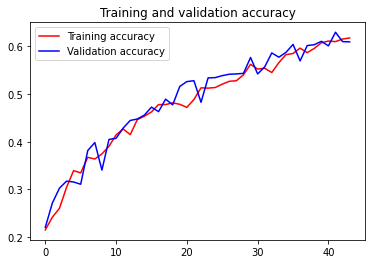

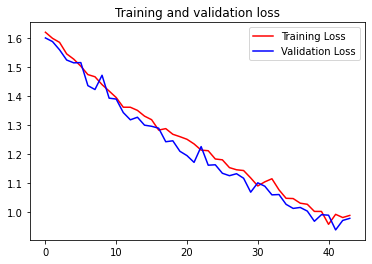

In [ ]:
  ## just run the bellow cell and see the acc and loss plots

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def load_and_predict(model, path):
  '''
  This function is used to generate the models predictions on test data

  If you loaded your data in other way please change the function to produce your predictions correctly

  If not, just run the cell
  '''
  test_generator = ImageDataGenerator(rescale=1. / 255)

  test_iterator = test_generator.flow_from_directory(
        path,
        target_size=(img_shape, img_shape),
        shuffle=False,
        class_mode='categorical',
        batch_size=1) 

  ids = []
  for filename in test_iterator.filenames:
    print(filename)
    ids.append(filename)

  predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
  predictions = []
  for index, prediction in enumerate(predict_result):
    classes = np.argmax(prediction)
    predictions.append([ids[index], classes])
  predictions.sort()

  return predictions

In [ ]:
def store_prediction(model_path, test_data_path, result_path):
  '''
  A function to run the load and predict function

  just run the cell
  '''
  model = keras.models.load_model(model_path, compile = True)

  predictions = load_and_predict(model, test_data_path)

  df = pd.DataFrame(data=predictions, columns=['image_id', 'label'])
  df = df.set_index(['image_id'])

  print(df.head())
  print('Writing submission')
  df.to_csv(result_path)

In [ ]:
store_prediction('./models/cnn_model.hdf5', './data/test/', './results.csv')

Found 422 images belonging to 5 classes.
iranKhodro_dena/10.jpg
iranKhodro_dena/106.jpg
iranKhodro_dena/109.jpg
iranKhodro_dena/118.jpg
iranKhodro_dena/121.jpg
iranKhodro_dena/127.jpg
iranKhodro_dena/13.jpg
iranKhodro_dena/139.jpg
iranKhodro_dena/147.jpg
iranKhodro_dena/148.jpg
iranKhodro_dena/152.jpg
iranKhodro_dena/156.jpg
iranKhodro_dena/161.jpg
iranKhodro_dena/177.jpg
iranKhodro_dena/184.jpg
iranKhodro_dena/185.jpg
iranKhodro_dena/191.jpg
iranKhodro_dena/193.jpg
iranKhodro_dena/2.jpg
iranKhodro_dena/200.jpg
iranKhodro_dena/201.jpg
iranKhodro_dena/205.jpg
iranKhodro_dena/207.jpg
iranKhodro_dena/208.jpg
iranKhodro_dena/209.jpg
iranKhodro_dena/215.jpg
iranKhodro_dena/216.jpg
iranKhodro_dena/224.jpg
iranKhodro_dena/229.jpg
iranKhodro_dena/231.jpg
iranKhodro_dena/237.jpg
iranKhodro_dena/239.jpg
iranKhodro_dena/250.jpg
iranKhodro_dena/252.jpg
iranKhodro_dena/253.jpg
iranKhodro_dena/257.jpg
iranKhodro_dena/26.jpg
iranKhodro_dena/260.jpg
iranKhodro_dena/261.jpg
iranKhodro_dena/267.jpg
iran

Here your own CNN model implementation has done

## **Transfer learning from a pre-trained model**

This implementation is as the same to the previous one except in the model creation and training sections

So use the other ones for code simplicity 

In [ ]:
def create_cnn_model():
  from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
  '''
  In this function you need to implement a cnn model from pre-trained one

  We recommand use the MobileNetV2 network

  See the bellow link:

  https://keras.io/api/applications/mobilenet/

  don't forget to fine-tune the last layer

  Use the imagenet weights

  '''
  #####################################
  ##### Your implementation here ######    
  MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=(img_shape, img_shape, 3),
                                            alpha=1.0,
                                            include_top=False,
                                            weights="imagenet",
                                            input_tensor=None,
                                            pooling=None,
                                            classes=5,
                                            classifier_activation="softmax",
                                        )
  
  model = Sequential()
  model.add(MobileNetV2)
  model.add(layers.Flatten())
  model.add(layers.Dense(5, activation='softmax'))
  

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )


  #####################################
  return model

In [ ]:
## train the model but don't forget adapte the hyper-parameters

history=train_model_naive_split()

Found 1680 images belonging to 5 classes.
Found 422 images belonging to 5 classes.
Epoch 1/10
84/84 [==============================] - 61s 674ms/step - loss: 2.6877 - accuracy: 0.4190 - val_loss: 41.0167 - val_accuracy: 0.1952 - lr: 0.0010
Epoch 2/10
84/84 [==============================] - 53s 630ms/step - loss: 2.9467 - accuracy: 0.5339 - val_loss: 62.9653 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 3/10
84/84 [==============================] - 53s 637ms/step - loss: 2.8646 - accuracy: 0.4048 - val_loss: 25.3874 - val_accuracy: 0.1964 - lr: 0.0010
Epoch 4/10
84/84 [==============================] - 56s 667ms/step - loss: 1.7126 - accuracy: 0.5095 - val_loss: 13.9741 - val_accuracy: 0.2119 - lr: 0.0010
Epoch 5/10
84/84 [==============================] - 52s 623ms/step - loss: 1.4957 - accuracy: 0.6030 - val_loss: 65.6506 - val_accuracy: 0.1952 - lr: 0.0010
Epoch 6/10
84/84 [==============================] - 52s 622ms/step - loss: 1.1221 - accuracy: 0.6542 - val_loss: 12.3995 - val_accur

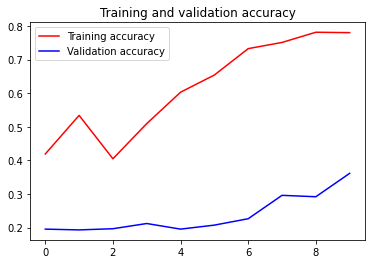

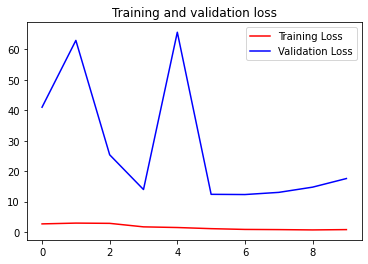

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
store_prediction('./models/cnn_model.hdf5', './data/test/', './results.csv')

Found 422 images belonging to 5 classes.
iranKhodro_dena/10.jpg
iranKhodro_dena/106.jpg
iranKhodro_dena/109.jpg
iranKhodro_dena/118.jpg
iranKhodro_dena/121.jpg
iranKhodro_dena/127.jpg
iranKhodro_dena/13.jpg
iranKhodro_dena/139.jpg
iranKhodro_dena/147.jpg
iranKhodro_dena/148.jpg
iranKhodro_dena/152.jpg
iranKhodro_dena/156.jpg
iranKhodro_dena/161.jpg
iranKhodro_dena/177.jpg
iranKhodro_dena/184.jpg
iranKhodro_dena/185.jpg
iranKhodro_dena/191.jpg
iranKhodro_dena/193.jpg
iranKhodro_dena/2.jpg
iranKhodro_dena/200.jpg
iranKhodro_dena/201.jpg
iranKhodro_dena/205.jpg
iranKhodro_dena/207.jpg
iranKhodro_dena/208.jpg
iranKhodro_dena/209.jpg
iranKhodro_dena/215.jpg
iranKhodro_dena/216.jpg
iranKhodro_dena/224.jpg
iranKhodro_dena/229.jpg
iranKhodro_dena/231.jpg
iranKhodro_dena/237.jpg
iranKhodro_dena/239.jpg
iranKhodro_dena/250.jpg
iranKhodro_dena/252.jpg
iranKhodro_dena/253.jpg
iranKhodro_dena/257.jpg
iranKhodro_dena/26.jpg
iranKhodro_dena/260.jpg
iranKhodro_dena/261.jpg
iranKhodro_dena/267.jpg
iran

## **Grad-CAM**
For some random images from different classes, show the heatmaps based on the grad-cam algorithm that you have learned.